In [1]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)


In [2]:
# CCI conditions and their points
cci_conditions = {
    'myocardial_infarction': 1,
    'congestive_heart_failure': 1,
    'peripheral_vascular_disease': 1,
    'cerebrovascular_disease': 1,
    'dementia': 1,
    'chronic_pulmonary_disease': 1,
    'connective_tissue_disease': 1,
    'ulcer_disease': 1,
    'mild_liver_disease': 1,
    'diabetes': 1,
    'hemiplegia': 2,
    'moderate_severe_renal_disease': 2,
    'diabetes_with_complications': 2,
    'any_tumor': 2,
    'leukemia': 2,
    'lymphoma': 2,
    'moderate_severe_liver_disease': 3,
    'metastatic_solid_tumor': 6,
    'AIDS': 6
}


In [3]:
def generate_patient_features(n=1000):
    data = []
    for _ in range(n):
        age = np.random.randint(30, 85)
        bmi = round(np.random.uniform(18, 40), 1)
        oa_severity = np.random.randint(1, 5)  # 1-4
        activity = np.random.randint(0, 3)  # 0=low,1=medium,2=high
        smoking = np.random.choice([0, 1])
        pain_score = round(np.random.uniform(1, 10), 1)
        data.append([age, bmi, oa_severity, activity, smoking, pain_score])
    df = pd.DataFrame(data, columns=['age', 'bmi', 'oa_severity', 'activity', 'smoking', 'pain_score'])
    return df


In [4]:
def assign_comorbidities(df, noise_level=0.15):
    comorbidities = []
    for _, row in df.iterrows():
        patient = {}
        # Simulate condition presence based on feature thresholds
        patient['myocardial_infarction'] = int(row['age'] > 60 and row['smoking'] == 1)
        patient['congestive_heart_failure'] = int(row['age'] > 65 and row['bmi'] > 30)
        patient['diabetes'] = int(row['bmi'] > 30 or row['age'] > 55)
        patient['chronic_pulmonary_disease'] = int(row['smoking'] == 1)
        patient['dementia'] = int(row['age'] > 70)
        patient['mild_liver_disease'] = int(row['bmi'] > 35)
        
        # Add noise (flip 10–20% of the conditions randomly)
        for cond in patient:
            if np.random.rand() < noise_level:
                patient[cond] = 1 - patient[cond]
        
        comorbidities.append(patient)
    
    comorb_df = pd.DataFrame(comorbidities)
    return pd.concat([df, comorb_df], axis=1)


In [5]:
def compute_cci(df):
    # Compute CCI score as sum of points
    df['cci_score'] = 0
    for cond, points in cci_conditions.items():
        if cond in df.columns:
            df['cci_score'] += df[cond] * points
    
    # Categorize risk: 0=low, 1-2=moderate, 3+=high
    df['cci_risk'] = pd.cut(df['cci_score'], bins=[-1,0,2,100], labels=['low','moderate','high'])
    return df


In [6]:
# Step 6: Generate data
df = generate_patient_features(5000)
df = assign_comorbidities(df, noise_level=0.15)
df = compute_cci(df)

# Preview
print(df.head())
print(df['cci_risk'].value_counts())


   age   bmi  oa_severity  activity  smoking  pain_score  \
0   68  35.5            3         2        1         6.4   
1   68  27.8            3         2        0         8.8   
2   65  21.1            3         1        0         9.7   
3   73  38.6            2         0        0         3.7   
4   51  18.2            1         0        0         6.5   

   myocardial_infarction  congestive_heart_failure  diabetes  \
0                      1                         1         1   
1                      0                         0         1   
2                      0                         0         1   
3                      0                         1         1   
4                      1                         0         0   

   chronic_pulmonary_disease  dementia  mild_liver_disease  cci_score  \
0                          1         0                   1          5   
1                          0         0                   0          1   
2                          1       

In [7]:
from sklearn.utils import resample

# Separate classes
low = df[df['cci_risk'] == 'low']
moderate = df[df['cci_risk'] == 'moderate']
high = df[df['cci_risk'] == 'high']

# Find max class count
max_count = max(len(low), len(moderate), len(high))

# Upsample each class to max_count
low_upsampled = resample(low, replace=True, n_samples=max_count, random_state=42)
moderate_upsampled = resample(moderate, replace=True, n_samples=max_count, random_state=42)
high_upsampled = resample(high, replace=True, n_samples=max_count, random_state=42)

# Combine
df_balanced = pd.concat([low_upsampled, moderate_upsampled, high_upsampled])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
print(df_balanced['cci_risk'].value_counts())


cci_risk
low         2421
moderate    2421
high        2421
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Features
X = df_balanced[['age', 'bmi', 'oa_severity', 'activity', 'smoking', 'pain_score']]

# Target
y = df_balanced['cci_risk']

# Encode target labels (low=0, moderate=1, high=2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [12]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize model
model = ExtraTreesClassifier(n_estimators=200, random_state=42)

# Train
model.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


Accuracy: 0.9139710942876806

Classification Report:
               precision    recall  f1-score   support

        high       0.90      0.89      0.90       484
         low       0.95      1.00      0.97       484
    moderate       0.89      0.85      0.87       485

    accuracy                           0.91      1453
   macro avg       0.91      0.91      0.91      1453
weighted avg       0.91      0.91      0.91      1453



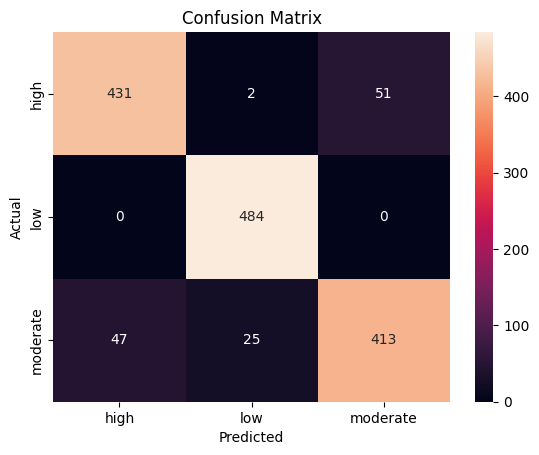

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict
y_pred = model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [13]:
import joblib

# Save model
joblib.dump(model, 'cci_risk_model.pkl')

# Save label encoder
joblib.dump(le, 'cci_label_encoder.pkl')

print("✅ Model and label encoder saved.")


✅ Model and label encoder saved.


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas as pd
import joblib


In [17]:
# Features
X = df_balanced[['age', 'bmi', 'oa_severity', 'activity', 'smoking', 'pain_score']]

# Target
y = df_balanced['cci_risk']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [18]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
}


In [21]:
results = []
accuracy_dict = {}  # To store all accuracies

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    accuracy_dict[name] = acc  # Store accuracy
    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print("-"*50)

# Print all accuracies neatly
print("\nAll Model Accuracies:")
for model_name, acc in accuracy_dict.items():
    print(f"{model_name}: {acc:.4f}")


Model: RandomForest
Accuracy: 0.9195
              precision    recall  f1-score   support

        high       0.92      0.90      0.91       484
         low       0.93      1.00      0.96       484
    moderate       0.90      0.86      0.88       485

    accuracy                           0.92      1453
   macro avg       0.92      0.92      0.92      1453
weighted avg       0.92      0.92      0.92      1453

--------------------------------------------------
Model: ExtraTrees
Accuracy: 0.9140
              precision    recall  f1-score   support

        high       0.90      0.89      0.90       484
         low       0.95      1.00      0.97       484
    moderate       0.89      0.85      0.87       485

    accuracy                           0.91      1453
   macro avg       0.91      0.91      0.91      1453
weighted avg       0.91      0.91      0.91      1453

--------------------------------------------------
Model: GradientBoosting
Accuracy: 0.7811
              precision

In [22]:
# Get model with highest accuracy
best_model_name, best_acc = max(results, key=lambda x: x[1])
best_model = models[best_model_name]

print(f"✅ Best model: {best_model_name} with accuracy {best_acc:.4f}")

# Save best model and label encoder
joblib.dump(best_model, 'best_cci_model.pkl')
joblib.dump(le, 'cci_label_encoder.pkl')


✅ Best model: RandomForest with accuracy 0.9195


['cci_label_encoder.pkl']